# Clustering Urban Areas

This notebook shows how tessellation can be used to generate clustering units in order to segment urban areas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (8,8)

import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import contextily as ctx

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [38]:
# Shapely 1.8.1 makes pandas to produce many warnings; this is to get rid of these warnings
import warnings
warnings.simplefilter("ignore")

In [4]:
from tesspy import Tessellation

## Area

We use **Frankfurt am Main** in Germany as a case study. First, we get the city boundary. 

In [5]:
ffm= Tessellation('Frankfurt am Main')
ffm_polygon=ffm.get_polygon()

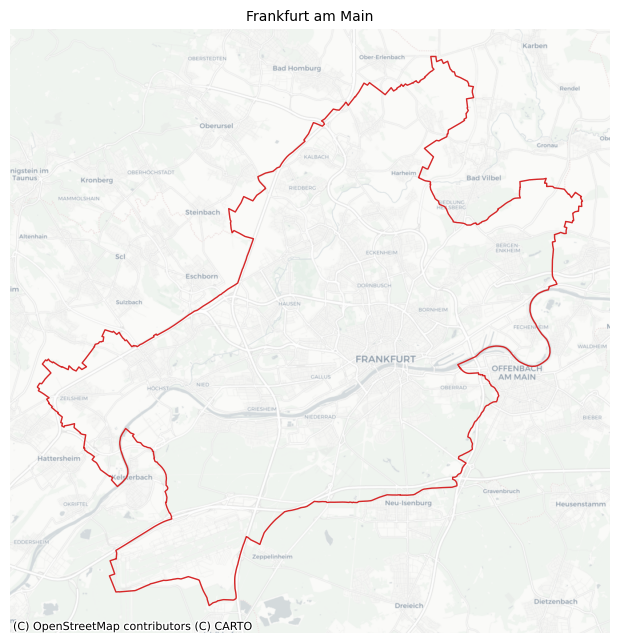

In [6]:
# visualization of area
ax= ffm_polygon.to_crs('EPSG:3857').plot(facecolor='none', edgecolor='tab:red',lw=1)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('Frankfurt am Main', fontsize=10)
plt.show()

## Tessellation

We tessellate the area using Voronoi Diagrams.

In [7]:
poi_categories=['shop','building','amenity','office','public_transport']

# voronoi Diagrams
ffm_voronoi_kmeans= ffm.voronoi(poi_categories=poi_categories, n_polygons=1000)

In [8]:
# adding an ID to tiles
ffm_voronoi_kmeans.reset_index(inplace=True)
ffm_voronoi_kmeans.rename(columns={'index':'tile_id'}, inplace=True)

# check polygons
ffm_voronoi_kmeans.tail()

,tile_id,geometry
917,994,"POLYGON ((8.69887 50.10739, 8.70045 50.10867, ..."
918,995,"POLYGON ((8.72891 50.09957, 8.73156 50.09439, ..."
919,996,"POLYGON ((8.64662 50.11059, 8.64275 50.10865, ..."
920,997,"POLYGON ((8.66783 50.10082, 8.67002 50.09716, ..."
921,999,"POLYGON ((8.61203 50.18259, 8.61447 50.18296, ..."


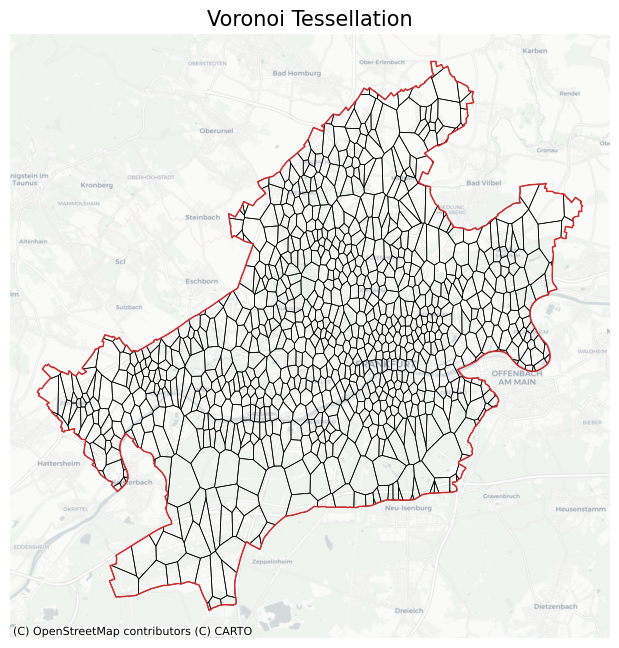

In [9]:
ax= ffm_voronoi_kmeans.to_crs('EPSG:3857').plot(facecolor='none', edgecolor='k', lw=0.5)
ffm_polygon.to_crs('EPSG:3857').plot(ax=ax, facecolor='none', edgecolor='tab:red',lw=1)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('Voronoi Tessellation', fontsize=15)
plt.show()

## Data Processing

We create count variables. For each polygon (tile), the number of each POI category is calculated.

In [39]:
# create a GeoDataFrame of POI data
poi_df= ffm.get_poi_data()
poi_geodata=gpd.GeoDataFrame(data=poi_df.drop(columns=['geometry']),
                              geometry=poi_df[['center_longitude','center_latitude']].apply(Point, axis=1).values,
                              crs='EPSG:4326')

In [11]:
poi_geodata.head()

,type,tags,center_latitude,center_longitude,amenity,building,office,public_transport,shop,geometry
0,way,"{'access': 'customers', 'amenity': 'parking', ...",50.107625,8.734458,True,False,False,False,False,POINT (8.73446 50.10762)
1,way,"{'amenity': 'school', 'contact:email': 'schull...",50.167461,8.675039,True,False,False,False,False,POINT (8.67504 50.16746)
2,way,"{'amenity': 'prison', 'barrier': 'fence', 'nam...",50.149950,8.695300,True,False,False,False,False,POINT (8.69530 50.14995)
3,way,"{'addr:city': 'Frankfurt am Main', 'addr:house...",50.145195,8.650782,True,False,False,False,False,POINT (8.65078 50.14519)
4,way,"{'addr:city': 'Frankfurt am Main', 'addr:postc...",50.052712,8.568809,False,True,False,False,False,POINT (8.56881 50.05271)


In [12]:
# Count POI
poi_counts= gpd.sjoin(ffm_voronoi_kmeans, poi_geodata, how='left', predicate='contains')
poi_counts[poi_categories]=poi_counts[poi_categories].applymap(lambda x: np.nan if not x else x)
poi_counts= poi_counts.groupby(by='tile_id').count().reset_index()
poi_counts.head()

,tile_id,geometry,index_right,type,tags,center_latitude,center_longitude,amenity,building,office,public_transport,shop
0,0,255,255,255,255,255,255,8,234,0,10,3
1,1,297,297,297,297,297,297,20,277,0,0,0
2,2,216,216,216,216,216,216,0,214,0,2,0
3,3,171,171,171,171,171,171,3,169,0,0,0
4,4,243,243,243,243,243,243,11,225,0,4,3


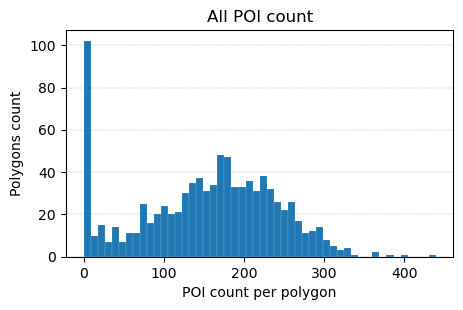

In [13]:
fig,ax=plt.subplots(figsize=(5,3))
poi_counts['type'].plot(kind='hist', bins=50, ax=ax, lw=0.1, edgecolor='white',zorder=3)
ax.set_title('All POI count')
ax.set_xlabel('POI count per polygon')
ax.set_ylabel('Polygons count')
ax.grid(axis='y',lw=0.3, ls='--',zorder=0)

We normalize the data using `MinMaxScaler`.

In [14]:
data=poi_counts[poi_categories].values
data_norm = MinMaxScaler().fit_transform(data)

## Clustering

K-Means is used for clustering polygons. 

In [15]:
kmc= KMeans(n_clusters=4, random_state=0).fit(data_norm)

In [22]:
clustering_results= gpd.GeoDataFrame(geometry=ffm_voronoi_kmeans['geometry'],
                                     data=poi_counts[poi_categories])
clustering_results['cluster']=kmc.labels_

# pretiffy the results
dct_= dict(zip(clustering_results.groupby('cluster').count().sort_values('geometry',ascending=False).index,
               clustering_results.groupby('cluster').count().index))
def sort_class_labels(i, dct):
    return dct[i]
clustering_results['cluster']=clustering_results['cluster'].apply(lambda x: sort_class_labels(x,dct_))

## Results

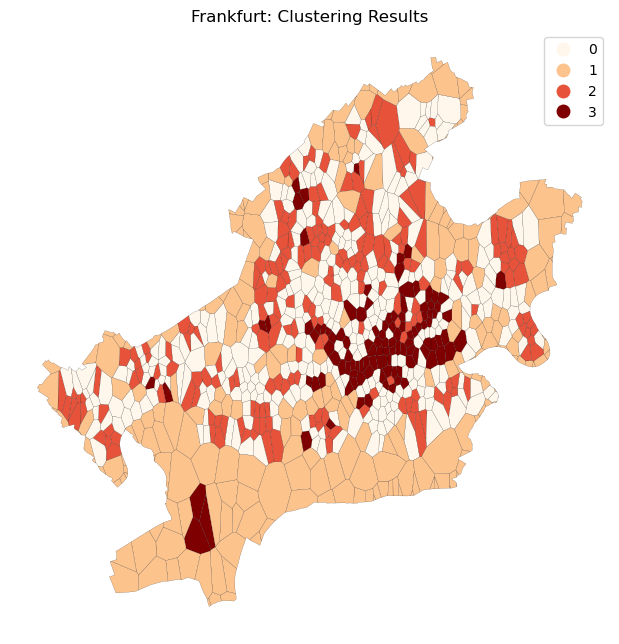

In [23]:
fig,ax=plt.subplots()
ax.set_axis_off()
clustering_results.plot(column='cluster', categorical=True, cmap='OrRd',linewidth=0.1,
                        edgecolor='k', legend=True, ax=ax)
ax.set_title(f'Frankfurt: Clustering Results')
plt.show()

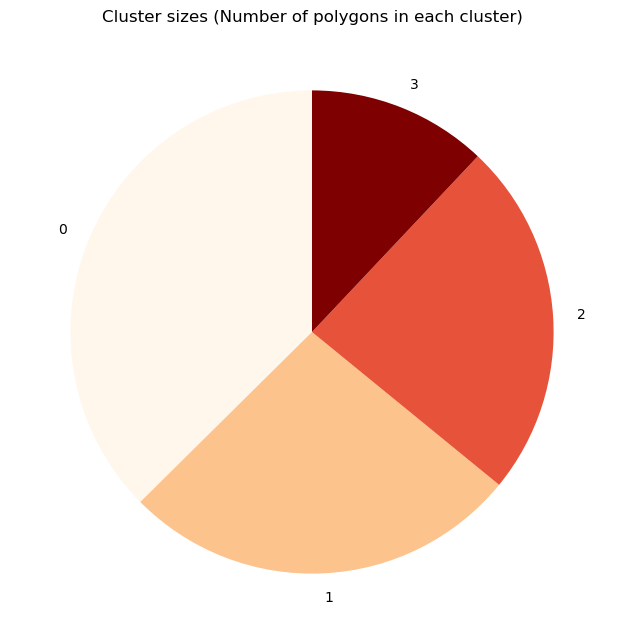

In [25]:
from matplotlib import cm
cs=cm.OrRd(np.linspace(0,1,4))

fig,ax=plt.subplots() 
labels = clustering_results['cluster'].value_counts().index
sizes = clustering_results['cluster'].value_counts().values
ax.pie(sizes, labels=labels,startangle=90, colors=cs)
ax.set_title(f'Cluster sizes (Number of polygons in each cluster)') 

plt.show()

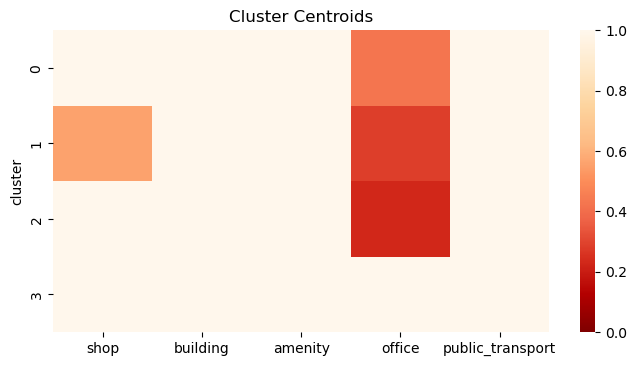

In [37]:
cluster_centroids = clustering_results.groupby('cluster').mean()
fig,ax =plt.subplots(figsize=(8,4))
sns.heatmap(cluster_centroids, ax=ax, cmap='OrRd_r',vmin=0, vmax=1)
ax.set_title(f'Cluster Centroids')   
plt.show()